# Introduction

The following python script (jupyter notebook) run a dispersal simulation by combining an oceanographic model and Lagrangian particle tracking methods using 'ocean PARCELS'.

In this simulation we carry out an example of how copepod larvae could disperse from a single target vent site in the Western Pacific at a single depth. We utilize observations of the copepods temperature dependent growth rate to determine the duration of its dispersal.

This script is a small-scale example of other scripts that use many more dispersing particles from multiple vents at multiple depths.

In [6]:
import numpy as np


In [1]:
import pymbolic
#!pip3 install --user geos
import geos
#!pip3 install --user proj
import proj
import netCDF4
from netCDF4 import Dataset,num2date 
import parcels as py
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, AdvectionRK4_3D, AdvectionDiffusionM1, ErrorCode, ParcelsRandom, Variable, VectorField, DiffusionUniformKh, plotTrajectoriesFile
import numpy as np
import math
from datetime import datetime
from datetime import timedelta
from operator import attrgetter
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

from copy import copy
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from IPython.display import Image

import itertools
import random

import cftime

from scipy import interpolate #Solution to 'AttributeError: ErrorInterpolation'?
import os

import matplotlib as mpl
import cmocean
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, writers, PillowWriter
from IPython.display import HTML
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
import matplotlib.patches as patches

import sys


ModuleNotFoundError: No module named 'geos'

## Specify the features of this specific run for filenaming

In [2]:
#ID
runID = "final"

v=int(sys.argv[1]) #iterate over sites 

#altitude above the hydrothermal vent        
r_alt = 100

NameError: name 'sys' is not defined

## Set number of Particles

In [3]:
#INPUT the number of particles and runtime for the simulation

rel_time= 6 * 365 #number of days to release particles

runtime = rel_time +100 #number of days to run the simulation

n = rel_time *4  # Number of particle release occurences (day/4 = 6hrs)

cloud = 100 #Number of particles released at every occurence



In [4]:
print(n*cloud,'particles in total: ',cloud,'particles released every six hours', n, 'times (',rel_time, 'days)', 'in a simulation that lasts ', runtime,' days')


876000 particles in total:  100 particles released every six hours 8760 times ( 2190 days) in a simulation that lasts  2290  days


# Import Data

Metadata used to inform the behaviour of dispersing partcles as well as the oceanographic data from models will inform this simulation

## Vent Metadata

In [5]:
#Import location of vent data
vent_sites=pd.read_csv('data/lau_vent_sites.csv', index_col = 'vent_field')
vent_sites

,lat,lon,depth
vent_field,,,
Mangatolo,-15.416017,-174.655517,2039
Tahi Moana,-20.690000,-176.180000,2256
ABE,-20.763050,-176.191300,2153
Tui Malila,-21.989133,-176.568317,1886
Tow Cam,-20.320000,-176.140000,2700
Kilo Moana,-20.050000,-176.130000,2620
Fatu Kapa,-14.750000,-177.150000,1500


## Select vent site

In [6]:
#v=int(sys.argv[1]) #Iteratively select vents
v = 2
vent_name=str(vent_sites.index[v])
v_name = vent_name.replace(" ", "_")
vent_name

'Tahi Moana'

## Oceanographic Data

In [7]:
#Import some example oceanographic data (1 day of U and V velocity data) to view its details in an 'xarray' structure
data_path = '../MERCATOR_cwp/'

merc_egu = xr.open_dataset(data_path + 'glorys12v1_p_2010-12-29T12:00:00.000000000_U.nc')
merc_egv = xr.open_dataset(data_path + 'glorys12v1_p_2010-12-29T12:00:00.000000000_V.nc')

merc_egu


<xarray.Dataset>
Dimensions:       (y: 700, x: 700, deptht: 50)
Coordinates:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
  * deptht        (deptht) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * x             (x) int32 801 802 803 804 805 806 ... 1496 1497 1498 1499 1500
  * y             (y) int32 1001 1002 1003 1004 1005 ... 1697 1698 1699 1700
    time_counter  datetime64[ns] ...
Data variables:
    vozocrtx      (deptht, y, x) float32 ...
    sozotaux      (y, x) float32 ...
    sotkeavmu1    (y, x) float32 ...
    sotkeavmu15   (y, x) float32 ...
    sotkeavmu30   (y, x) float32 ...
    sotkeavmu50   (y, x) float32 ...
Attributes:
    Conventions:  CF-1.0
    file_name:    GLORYS12V1_y2020m05d30_gridU.nc
    institution:  MERCATOR OCEAN
    source:       NEMO
    TimeStamp:    2021-SEP-02 22:11:01 GMT-0000
    references:   http://www.mercator-ocean.eu

Import the static files associated with the oceanographic data that contains information on the grid structure

More information can be found at: https://www.mercator-ocean.eu/static-files-description/

In [8]:
#Import the static files associated with the oceanographic data that contains information on the grid structure
hgr = xr.open_dataset(data_path+'glorys12v1_p_hgr.nc')
zgr = xr.open_dataset(data_path+'glorys12v1_p_zgr.nc')
hgr

<xarray.Dataset>
Dimensions:       (y: 700, x: 700, z: 50, t: 1)
Dimensions without coordinates: y, x, z, t
Data variables: (12/21)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    glamt         (t, y, x) float32 ...
    glamu         (t, y, x) float32 ...
    ...            ...
    e1f           (t, y, x) float64 ...
    e2t           (t, y, x) float64 ...
    e2u           (t, y, x) float64 ...
    e2v           (t, y, x) float64 ...
    e2f           (t, y, x) float64 ...
    ff            (t, y, x) float64 ...
Attributes:
    file_name:                       mesh_hgr.nc
    TimeStamp:                       03/02/2016 10:24:55 -0000
    DODS_EXTRA.Unlimited_Dimension:  t

In [9]:
# Specify the 2D location of the U and V data 
glamt = hgr.glamt[0,:,:].values
gphit = hgr.gphit[0,:,:].values

![PARCELS RK4 Interpolation](https://ars.els-cdn.com/content/image/1-s2.0-S1463500317301853-gr2.jpg)

**Sebill *et al*., 2018** (Creators of Ocean Parcels) - Fig. 2. Illustration of time stepping solutions on an Arakawa C-grid with edges of non-dimensional length=1. Velocities (u, v) across the four edges are given in numbers at the magenta dots. The blue arrows are the linearly interpolated velocities within the grid. Assume particles are released on the 
 (left) edge. The red lines are pathlines of the analytical solution for these particles. The cyan piecewise linear lines are the solutions to RK4 timestepping with 
. The two types of integration lead to similar solutions.  https://www.sciencedirect.com/science/article/pii/S1463500317301853

## Designate the Ocean Model netcdf file(s) that will act as the fieldset

In [10]:
#In this example I only use one year of oceanographic data
timestamps = np.expand_dims(np.arange(np.datetime64('2009-12-29'), np.datetime64('2018-01-01')),axis=1)

ufiles = sorted(glob(data_path+'glorys12v1_p_*U.nc'))
vfiles = sorted(glob(data_path+'glorys12v1_p_*V.nc'))
wfiles = sorted(glob(data_path+'glorys12v1_p_*W.nc'))
tfiles = sorted(glob(data_path+'glorys12v1_p_*T.nc'))


mesh_mask = data_path+'glorys12v1_p_hgr.nc'

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles},
             'T': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': tfiles}}

variables = {'U': 'vozocrtx',
             'V': 'vomecrty',
             'W': 'vovecrtz',
             'T': 'votemper'}

dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'T': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions,vmin=-2000, timestamps = timestamps,allow_time_extrapolation=True)



In [11]:
fieldmesh_x = fieldset.U.lon
fieldmesh_y = fieldset.U.lat

## Extract bathymetry values for each vent site

The bathymetry as specified by the maxmum depth of the oceanographic model may not match other sources based on the difference in resolution. It is important to release particles based on the bathymetry in this model to avoid releaseing particles into the seabed

In [12]:
bathyw = zgr.hdepw[0,:,:]
bathy_table=np.empty((1,3))

In [13]:

vent = vent_sites.iloc[v]
vent_site=str(vent_sites.index[v])

# Find absolute difference between requested point and the grid coordinates.
abslat = np.abs(hgr.gphit - vent.lat)
abslon = np.abs(hgr.glamt - vent.lon)

# Create grid of the maximum values of the two absolute grids
c = np.maximum(abslon, abslat)

ventloc= np.where(c == np.min(c))
ventloc = ventloc[1:]
vx,vy= int(ventloc[0]),int(ventloc[1])

v_bathy=int(zgr.hdepw[0,vx,vy])
bathy_table=np.vstack([bathy_table,(vent_site,vent_sites.depth[v],v_bathy)])
#if v_bathy<=r_depth:
print(vent_site, "bathymetry =",v_bathy)


Tahi Moana bathymetry = 2316


## Define the  Landmask

As with the bathymetry, the exact location of the land/seabed are specified within the oceanographic model. I define this 'landmask' in order to modify the diffusion of particles so that they do not diffuse into the land/seabed

In [16]:
#The mask 'static file' is also imported as an xarray
mask = xr.open_dataset(data_path+'glorys12v1_p_mask.nc')
mask

<xarray.Dataset>
Dimensions:       (y: 700, x: 700, z: 50, t: 1)
Dimensions without coordinates: y, x, z, t
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    tmask         (t, z, y, x) uint8 ...
    umask         (t, z, y, x) uint8 ...
    vmask         (t, z, y, x) uint8 ...
    fmask         (t, z, y, x) uint8 ...
    tmaskutil     (t, y, x) uint8 ...
    umaskutil     (t, y, x) uint8 ...
    vmaskutil     (t, y, x) uint8 ...
    fmaskutil     (t, y, x) uint8 ...
Attributes:
    file_name:                       mask.nc
    TimeStamp:                       03/02/2016 10:18:37 -0000
    DODS_EXTRA.Unlimited_Dimension:  t

In [17]:
# Designate the above data as a field to be used with PARCELS

mask = xr.open_dataset(data_path+'glorys12v1_p_mask.nc')
mask=mask.assign(fmask1=lambda x: mask.variables['fmask'])
mask['fmask1'].values = np.where(mask.fmask == 2,1, mask.fmask )
fmask=mask.fmask1[0,:,:,:]
fieldset.add_field(Field('fmask_ones', fmask, depth = fieldset.U.depth, lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, 
                          mesh='spherical',interp_method='nearest')) 

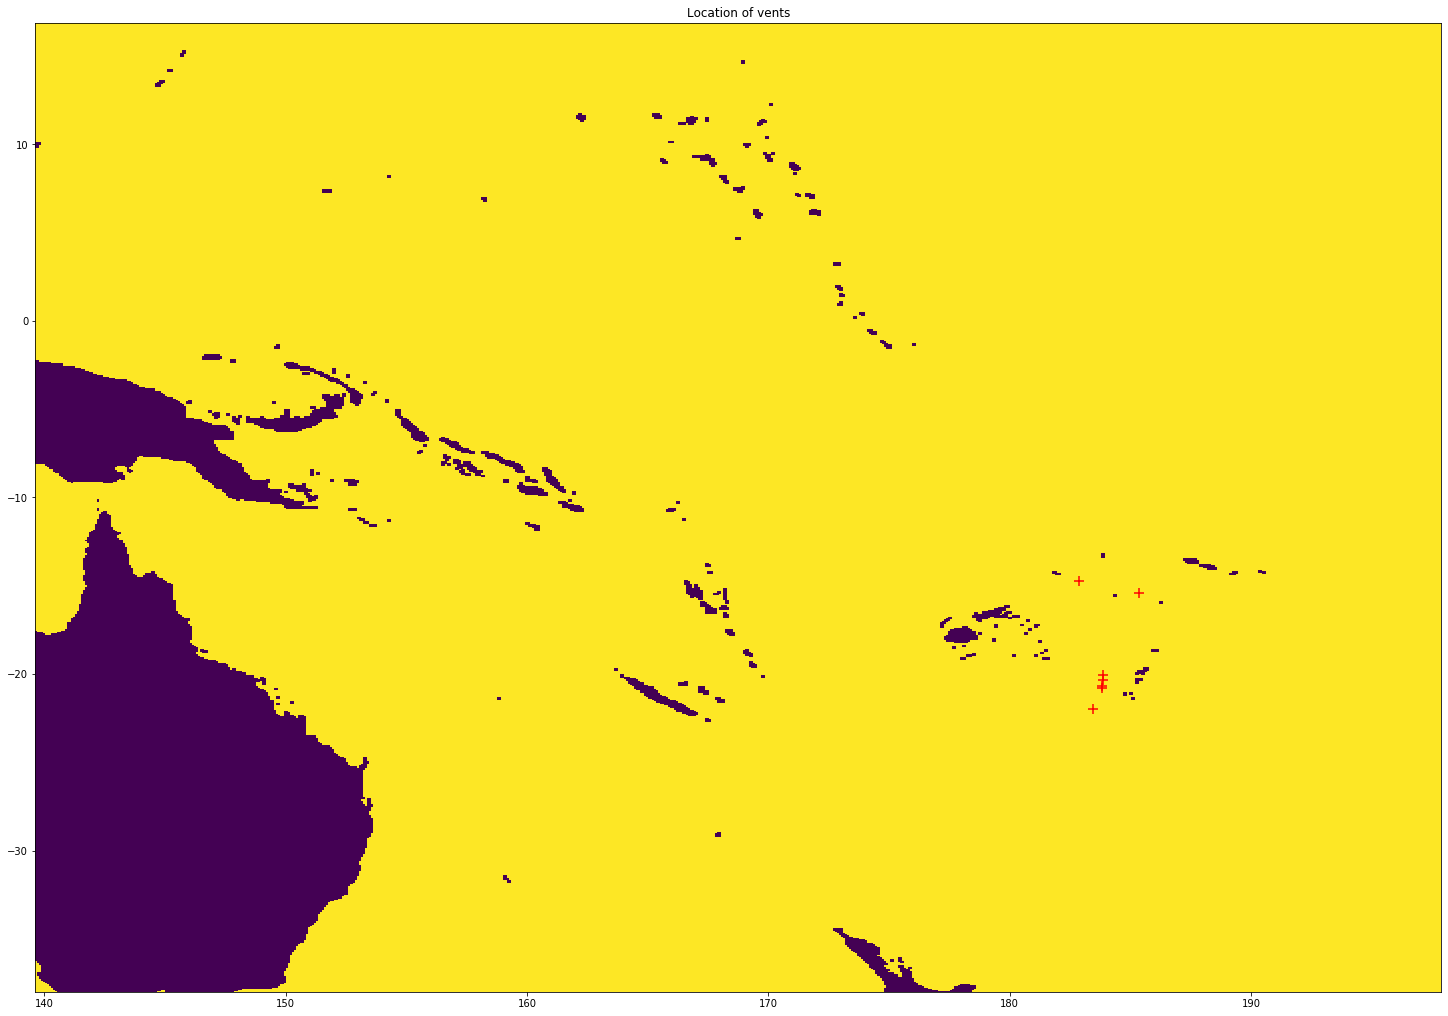

In [18]:
#Here I plot the landmask to qulaitatively check it is correct and makes snese with the position of vent sites

fig, ax = plt.subplots(
    1, 1, figsize=(20, 14),constrained_layout=True)

ax.set(title="Location of vents")

ax.pcolormesh(fieldset.U.grid.lon%360, fieldset.U.grid.lat,mask['fmask1'][0,0,:,:].values)

#ax.pcolormesh(mask.tmask[0,0,:,:] )

for i in range(0,len(vent_sites)):
    vent = vent_sites.iloc[i]
    vent_site=str(vent_sites.index[i])
    ax.scatter(vent.lon%360, vent.lat,c='red', s = 100, marker ='+', zorder = 100)



## Define diffusion¶
Example https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_diffusion.ipynb :

Using horizontal diffusion calculated from velocity fields In the case when velocity fields are available, there is the possibility to calculate coefficients of diffusion based on closure parameterizations. The Smagorinsky method (Smagorinsky, 1963), which was originally proposed as a parameterization for horizontal eddy viscosity, is often used to parameterize horizontal eddy diffusivity as well. 



In [19]:
# Diffusivity depends on the grid cell sizes (area_
cell_areas = hgr.e1u*hgr.e1v

fieldset.add_field(Field('cell_areas', cell_areas, lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, 
                          mesh='spherical',interp_method='nearest')) 

fieldset.add_constant('Cs', 0.1)

I have adapted this method to incorporate the land mask, ensuring that all diffusivity values approach 0 as they come into contact with a land cell. This prevents particles diffusing into the land and getting stuck there

In [20]:
def smagdiff_new(particle, fieldset, time):
    dx = 0.01
    # gradients are computed by using a local central difference.
    updx, vpdx = fieldset.UV[time, particle.depth, particle.lat, particle.lon+dx]
    umdx, vmdx = fieldset.UV[time, particle.depth, particle.lat, particle.lon-dx]
    updy, vpdy = fieldset.UV[time, particle.depth, particle.lat+dx, particle.lon]
    umdy, vmdy = fieldset.UV[time, particle.depth, particle.lat-dx, particle.lon]

    dudx = (updx - umdx) / (2*dx)
    dudy = (updy - umdy) / (2*dx)
    
    dvdx = (vpdx - vmdx) / (2*dx)
    dvdy = (vpdy - vmdy) / (2*dx)
    #selesct the mask
    M = fieldset.fmask_ones[time,particle.depth,particle.lat, particle.lon]###Added a mask multiplier
    
    A = fieldset.cell_areas[time, 0, particle.lat, particle.lon]
    sq_deg_to_sq_m = (1852*60)**2*math.cos(particle.lat*math.pi/180)
    A = A / sq_deg_to_sq_m
    Kh = fieldset.Cs  * M * A * math.sqrt(dudx**2 + 0.5*(dudy + dvdx)**2 + dvdy**2) ###Added a mask multiplier

    dlat = ParcelsRandom.normalvariate(0., 1.) * math.sqrt(2*math.fabs(particle.dt)* Kh) 
    dlon = ParcelsRandom.normalvariate(0., 1.) * math.sqrt(2*math.fabs(particle.dt)* Kh) 

    particle.lat += dlat
    particle.lon += dlon

### Define kernal behaviours

In [21]:
# Create a periodic boundary condition kernel
def periodicBC(particle, fieldset, time):
    if particle.lon > 180:
        particle.lon -= 360

In [22]:

b0 =2.9527588795846933 #Calculated based on inferences from Gollner et al. (2016)

b1 = -1.3439341
b2 = -0.2775613
T = 1
Tc = 15

(math.exp(2)*math.pow((T/15),(-1.4-0.27*math.log(T/15))))

45.20535669586904

In [23]:
def SampleTemp (particle, fieldset, time):
    particle.temp = fieldset.T[time, particle.depth , particle.lat, particle.lon] 
    
def ToTemp (particle, fieldset, time):
    particle.totemp += particle.temp
                                       
def AvTemp (particle, fieldset, time):
    particle.avtemp = particle.totemp/(particle.age/3600) 
    
#Adapted from O'Connor    
def growth (particle, fieldset, time):
    particle.growth = 1/(math.exp(2.9527588795846933)*math.pow((particle.temp/15),(-1.4-0.27*math.log(particle.temp/15))))
#Cumulative growth rate    
def maturity (particle, fieldset, time):
    particle.maturity += (particle.growth * particle.dt/86400)
    

In [24]:
#A kernel that  deletes a particle (solution to error messages)
def DeleteParticle(particle, fieldset, time):
    particle.delete()

# Record particle age for post-processing    
def SampleAge(particle, fieldset, time):
    particle.age += particle.dt 
    
    
#Kill the particle after it has reached the maturity threshold  
def Particle_death(particle, fieldset, time):
    if particle.maturity > 1:
        particle.delete()



In [25]:
def Distance(particle, fieldset, time):
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2 # latitudinal distance
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi/180) # longitudinal distance
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2)) # calculate Euclidean distance
    particle.prev_lon = particle.lon # Set the values for the next time step   
    particle.prev_lat = particle.lat
    

    

In [26]:
#Define the data that is recorded for each particle
class CustomParticle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=0)
    temperature = Variable('temp', dtype=np.float32, to_write=False)
    growth = Variable('growth', dtype=np.float32, initial=0, to_write=False)
    maturity = Variable('maturity', dtype=np.float32, initial=0)
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.
    totemp = Variable('totemp', dtype=np.float32, initial=0, to_write=False)
    avtemp = Variable('avtemp', dtype=np.float32)
 


##  Particle  set

In [ ]:
lat = list(np.repeat(vent_sites.at[vent_name,'lat'],n*cloud))
lon = list(np.repeat(vent_sites.at[vent_name,'lon'],n*cloud))

v_bathy=int(zgr.hdepw[0,vx,vy])
r_dep=v_bathy-r_alt
dep = list(np.repeat(r_dep,n*cloud))

start = pd.to_datetime('2009-12-29')
interval_start = pd.date_range(start = start, periods = n, freq = '6H')
interval_cloud= np.repeat(interval_start,cloud)

In [28]:
print(vent_name,lon[0],lat[0],v_bathy-r_alt)

Tahi Moana -176.18 -20.69 1316


In [29]:
print(vent_name,lon[0],lat[0],v_bathy-r_alt)

Tahi Moana -176.18 -20.69 1316


In [30]:

pset = ParticleSet(fieldset=fieldset, 
                   pclass=CustomParticle, 
                   lon=lon, 
                   lat=lat,
                   depth = dep,
                   time=interval_cloud) 



In [31]:
kernels = pset.Kernel(smagdiff_new)  + pset.Kernel(AdvectionRK4_3D)  + periodicBC +pset.Kernel(Particle_death)  + pset.Kernel(SampleAge)   + pset.Kernel(SampleTemp) +  pset.Kernel(growth) + pset.Kernel(maturity) 

In [ ]:
print(v_name,n*cloud,'particles released at',r_alt,'m altitude: ',cloud,'particles released every six hours', n, 'times (',rel_time, 'days)', 'in a simulation that lasts ', runtime,' days')

In [ ]:
output_file = pset.ParticleFile(name="output/"+runID+"_"+str(r_alt)+"m_alt"+v_name+".nc",write_ondelete=True ) # outputdt= timedelta(days=1)/write_ondelete=True. the file name and the time step of the outputs [I had issues with the 'timedelta' so i just changed it to a positive double (1)]
pset.execute(kernels,                 # the kernel (which defines how particles move)
             runtime= timedelta(days=runtime),    # the total length of the run
             dt= timedelta(hours=1),          # the timestep of the kernel
             recovery ={ErrorCode.ErrorOutOfBounds: DeleteParticle, 
                        ErrorCode.ErrorInterpolation: DeleteParticle},# How to handle error messages
             output_file=output_file)

In [33]:
output_file.export()